<a href="https://www.kaggle.com/code/colewelkins/ves3-0?scriptVersionId=128706365" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv
/kaggle/input/vesuvius-challenge-ink-detection/test/b/mask.png
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/05.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/18.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/46.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/01.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/45.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/07.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/17.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/29.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/19.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/38.tif
/kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/15.tif
/kaggle/input/vesuvius-challenge

# Import Libraries and set paths

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import glob
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed
from torchvision import transforms

# Constants
PREFIX = '/kaggle/input/vesuvius-challenge-ink-detection/train/3/'
BUFFER = 30
Z_START = 27
Z_DIM = 10
TRAINING_STEPS = 30000
LEARNING_RATE = 0.001
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load mask and label images
mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)

# Load the 3D x-ray scan, one slice at a time
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


In [3]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels, transform=None):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
        self.transform = transform

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        if self.transform:
            subvolume = self.transform(subvolume)
        return subvolume, inklabel

class InkDetectionModel(nn.Module):
    def __init__(self):
        super(InkDetectionModel, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(128)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(256)
        self.fc1 = nn.Linear(256 * (Z_DIM // 8) * ((BUFFER * 2 + 1) // 8) ** 2, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool3d(2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model
model = InkDetectionModel()

# Use DataParallel to wrap the model if there are multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to(DEVICE)

Using 2 GPUs


DataParallel(
  (module): InkDetectionModel(
    (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=12544, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
    (relu): ReLU()
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sigmoid): Sigmoid()
  )
)

# Train

In [4]:
# Define additional variables
rect = (1100, 3500, 700, 950)  # Rectangle used for evaluation

# Create a Boolean array of the same shape as the mask, initially all True
not_border = np.zeros(mask.shape, dtype=bool)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True
arr_mask = np.array(mask) * not_border

# Define pixels inside and outside the rectangle
inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True
outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False
pixels_inside_rect = np.argwhere(inside_rect)
pixels_outside_rect = np.argwhere(outside_rect)

# Create the training dataset and data loader
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)

# Data augmentation
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create the training dataset and data loader
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect, transform=data_transform)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)

# Training loop
model.train()
for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    if i >= TRAINING_STEPS:
        break
    subvolumes = subvolumes.to(DEVICE)
    inklabels = inklabels.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(subvolumes)
    loss = criterion(outputs, inklabels)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training progress
    if i % 1000 == 999:
        print(f"Step {i+1}/{TRAINING_STEPS}, Loss: {loss.item():.4f}")

print("Training complete.")

  3%|▎         | 1010/30000 [01:31<31:51, 15.16it/s]  

Step 1000/30000, Loss: 0.3022


  7%|▋         | 2011/30000 [02:52<31:10, 14.96it/s]  

Step 2000/30000, Loss: 0.3894


 10%|█         | 3011/30000 [04:12<30:08, 14.92it/s]  

Step 3000/30000, Loss: 0.3357


 13%|█▎        | 4009/30000 [05:32<31:57, 13.56it/s]  

Step 4000/30000, Loss: 0.3065


 17%|█▋        | 5010/30000 [06:52<27:33, 15.11it/s]  

Step 5000/30000, Loss: 0.5167


 20%|██        | 6011/30000 [08:12<26:46, 14.93it/s]  

Step 6000/30000, Loss: 0.2280


 23%|██▎       | 7011/30000 [09:32<25:47, 14.86it/s]  

Step 7000/30000, Loss: 0.5695


 27%|██▋       | 8011/30000 [10:52<24:37, 14.89it/s]  

Step 8000/30000, Loss: 0.2614


 30%|███       | 9011/30000 [12:12<23:31, 14.87it/s]  

Step 9000/30000, Loss: 0.4156


 33%|███▎      | 10011/30000 [13:32<22:20, 14.91it/s]

Step 10000/30000, Loss: 0.2187


 37%|███▋      | 11010/30000 [14:52<21:51, 14.47it/s]

Step 11000/30000, Loss: 0.1248


 40%|████      | 12011/30000 [16:12<20:13, 14.82it/s]

Step 12000/30000, Loss: 0.4196


 43%|████▎     | 13011/30000 [17:32<18:56, 14.94it/s]

Step 13000/30000, Loss: 0.2414


 47%|████▋     | 14011/30000 [18:52<17:52, 14.90it/s]

Step 14000/30000, Loss: 0.1665


 50%|█████     | 15011/30000 [20:12<16:47, 14.88it/s]

Step 15000/30000, Loss: 0.2979


 53%|█████▎    | 16011/30000 [21:32<15:38, 14.90it/s]

Step 16000/30000, Loss: 0.1266


 57%|█████▋    | 17011/30000 [22:52<14:29, 14.95it/s]

Step 17000/30000, Loss: 0.0868


 60%|██████    | 18011/30000 [24:12<13:21, 14.95it/s]

Step 18000/30000, Loss: 0.0824


 63%|██████▎   | 19011/30000 [25:32<12:19, 14.86it/s]

Step 19000/30000, Loss: 0.2676


 67%|██████▋   | 20011/30000 [26:52<11:08, 14.94it/s]

Step 20000/30000, Loss: 0.1962


 70%|███████   | 21011/30000 [28:12<10:01, 14.93it/s]

Step 21000/30000, Loss: 0.2295


 73%|███████▎  | 22011/30000 [29:32<08:54, 14.95it/s]

Step 22000/30000, Loss: 0.3190


 77%|███████▋  | 23011/30000 [30:52<07:48, 14.92it/s]

Step 23000/30000, Loss: 0.4453


 80%|████████  | 24011/30000 [32:12<06:41, 14.92it/s]

Step 24000/30000, Loss: 0.4296


 83%|████████▎ | 25011/30000 [33:32<05:33, 14.95it/s]

Step 25000/30000, Loss: 0.1490


 87%|████████▋ | 26011/30000 [34:52<04:26, 14.94it/s]

Step 26000/30000, Loss: 0.1315


 90%|█████████ | 27011/30000 [36:12<03:21, 14.86it/s]

Step 27000/30000, Loss: 0.0920


 93%|█████████▎| 28011/30000 [37:32<02:13, 14.85it/s]

Step 28000/30000, Loss: 0.1474


 97%|█████████▋| 29011/30000 [38:52<01:06, 14.94it/s]

Step 29000/30000, Loss: 0.1872


100%|██████████| 30000/30000 [40:11<00:00, 12.44it/s]

Step 30000/30000, Loss: 0.1116


Training complete.


100%|██████████| 41666/41666 [07:19<00:00, 94.78it/s]


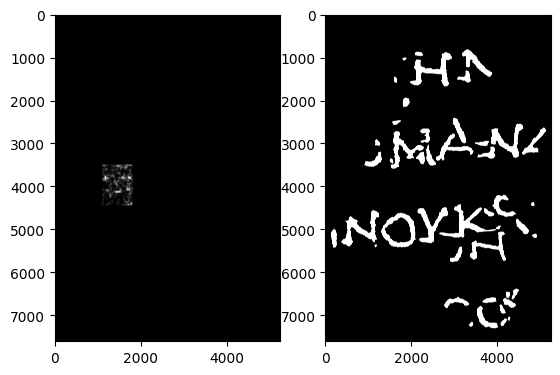

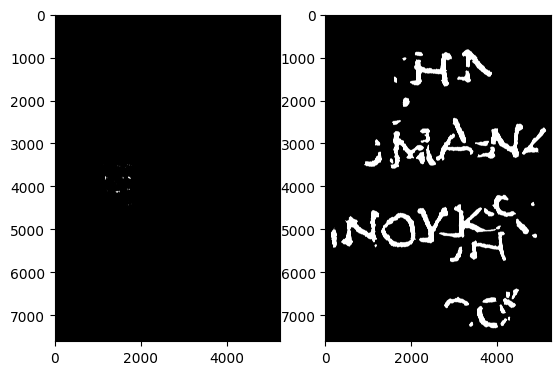

In [5]:
# Create the evaluation dataset and data loader
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize an output tensor to store predictions
output = torch.zeros_like(label).float()

# Evaluation loop
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            output[tuple(pixels_inside_rect[i*BATCH_SIZE+j])] = value

# Visualize the prediction results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

# Apply a threshold to the predictions to obtain binary output
THRESHOLD = 0.5  # Adjust the threshold value for better results
binary_output = output.gt(THRESHOLD).cpu()

# Visualize the binary prediction results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(binary_output, cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [6]:
# Function to generate run-length encoding (RLE) for the binary mask
def rle(output):
    pixels = np.where(output.flatten() > 0, 1, 0).astype(np.uint8)
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)

# Generate RLE for the binary output
rle_output = rle(binary_output)

# Save the RLE to a CSV file for submission
with open('submission.csv', 'w') as f:
    f.write("Id,Predicted\n")
    f.write("a," + rle_output + "\n")
    f.write("b," + rle_output + "\n")

print("Submission file 'submission.csv' has been generated.")

Submission file 'submission.csv' has been generated.
